In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split

import torch

import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

In [2]:
data_path = Path('../data/processed/data_processed.csv')

data = pd.read_csv(data_path.as_posix())

In [3]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [4]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

Try linear regression with one target variable, the continuous variable `comp1_life`:

In [6]:
cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4','comp1_life']

data_tst = data[cols]

In [7]:
X = data_tst.to_numpy()

# Keep the last column as target y
y = X[:,-1]
X = X[:,:-1]

In [8]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
      
    return y

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# # Prepare data for Pyro model
# X_train_small = torch.tensor(X[:100,:]).float()
# y_train_small = torch.tensor(y[:100]).float()

In [11]:
# # Run inference in Pyro
# nuts_kernel = NUTS(model)
# mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
# mcmc.run(X_train_small, y_train_small)

# # Show summary of inference results
# mcmc.summary()

In [12]:
# # Extract samples from posterior
# posterior_samples = mcmc.get_samples()

# sns.kdeplot(posterior_samples["alpha"])
# sns.kdeplot(posterior_samples["sigma"])

# # Alternative
# #sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
# #sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

# plt.legend(["alpha", "sigma"])
# plt.axis([-2,2,0,35])
# plt.show()

In [13]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X[:,:100]).float()
y_train_torch = torch.tensor(y[100]).float()

In [14]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

In [15]:
# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [16]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 25189711.6
[100] ELBO: 1871829.4
[200] ELBO: 1496215.8
[300] ELBO: 241229.6
[400] ELBO: 43519.3
[500] ELBO: 150411.1
[600] ELBO: 190689.0
[700] ELBO: 156497.7
[800] ELBO: 89750.5
[900] ELBO: 30571.6
[1000] ELBO: 25440.1
[1100] ELBO: 20649.5
[1200] ELBO: 19665.5
[1300] ELBO: 36276.2
[1400] ELBO: 19229.0
[1500] ELBO: 19562.7
[1600] ELBO: 18231.4
[1700] ELBO: 24253.6
[1800] ELBO: 19902.3
[1900] ELBO: 17668.4
[2000] ELBO: 19205.4
[2100] ELBO: 17595.3
[2200] ELBO: 17395.0
[2300] ELBO: 17072.0
[2400] ELBO: 17013.5
[2500] ELBO: 16090.8
[2600] ELBO: 16401.9
[2700] ELBO: 16811.6
[2800] ELBO: 17137.6
[2900] ELBO: 16975.3
[3000] ELBO: 15573.1
[3100] ELBO: 14703.6
[3200] ELBO: 15611.2
[3300] ELBO: 16324.3
[3400] ELBO: 15193.5
[3500] ELBO: 15147.2
[3600] ELBO: 15462.6
[3700] ELBO: 15634.4
[3800] ELBO: 13765.9
[3900] ELBO: 16764.1


In [17]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [18]:
y_std = y_train.std()
y_mean = y_train.mean()

In [19]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [20]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: -0.072
MAE: 1179.240
RMSE: 1820.893
R2: 0.000


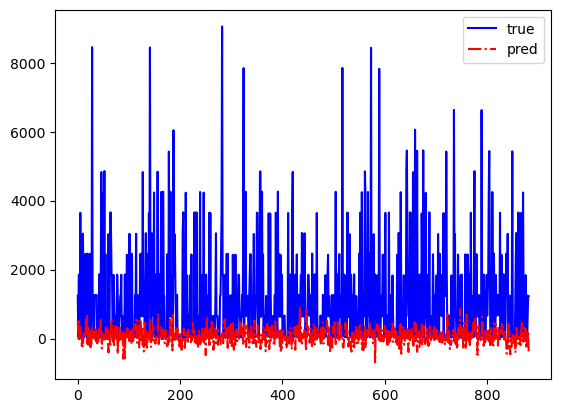

In [26]:
plt.plot(y_true, 'b-', label='true')
plt.plot(preds, 'r-.', label='pred')

plt.legend()

plt.show()